In [68]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import babet as bb
from moarpalettes import get_palette
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
from cmcrameri import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter, ScalarFormatter

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [69]:
def combine_xarray_dict(exp, dim_name="experiment"):
    """
    Combine a dictionary of xarray datasets into a single dataset along a new dimension.

    Parameters
    ----------
    exp : dict of {str: xr.Dataset}
        Dictionary where keys are experiment names and values are xarray datasets.
    dim_name : str, optional
        Name of the new dimension to combine along (default is "experiment").

    Returns
    -------
    xr.Dataset
        A combined dataset with an additional dimension corresponding to dictionary keys.
    """
    # Convert dictionary to a list of datasets and extract keys
    datasets = list(exp.values())
    keys = list(exp.keys())

    # Add the new dimension as a coordinate
    expanded_datasets = [ds.assign_coords({dim_name: key}) for ds, key in zip(datasets, keys)]

    # Concatenate along the new dimension
    combined_ds = xr.concat(expanded_datasets, dim=dim_name)

    return combined_ds

In [2]:
color_palette = get_palette.Petroff6().to_sn_palette()

In [ ]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 10, 48, 70]
northsea = [-17, 20, 40, 70]

inidate = '2023-10-15'

# Import data

In [3]:
# Load pre-calculated data from python script 09
upper = 250
lower = 1000
save_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/advection/'
fpath = os.path.join(save_dir, f'09_vert_integrated_adv_{lower}hPa_to_{upper}hPa_event-mean.nc')
adv = xr.open_dataset(fpath)

In [24]:
# Compute difference between experiments
diff_pi = (
    adv.mass_weighted_vdq.sel(inidate=inidate, experiment='pi').mean('number')
    - adv.mass_weighted_vdq.sel(inidate=inidate, experiment='curr').mean('number')
)

diff_incr = (
    adv.mass_weighted_vdq.sel(inidate=inidate, experiment='incr').mean('number')
    - adv.mass_weighted_vdq.sel(inidate=inidate, experiment='pi').mean('number')
)

In [21]:
# Load data for plot
save_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/q_s_and_w/'
fpath = os.path.join(save_dir, f'11_q_s_and_w_2023-10-15.nc')
qs_and_w = xr.open_dataset(fpath)

# Plot

In [70]:
# Define a custom formatter function for one decimal in scientific notation
def sci_notation_1dec(x, pos):
    return f"{x:.1e}"  # Converts to scientific notation with one decimal place

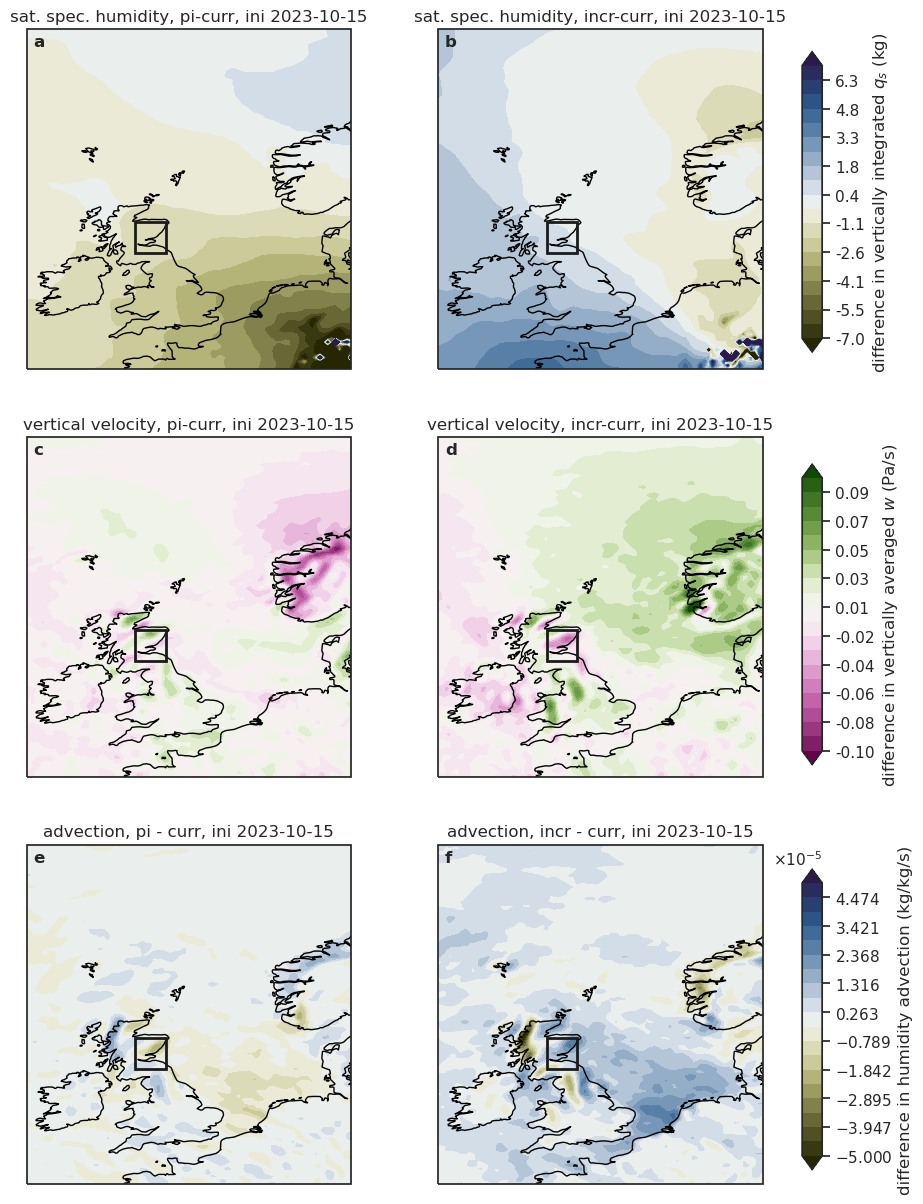

In [ ]:
# Create figure
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot saturation specific humidity
plot1 = (qs_and_w.sel(experiment='pi')-qs_and_w.sel(experiment='curr')).Q_s.plot.contourf(
    cmap=cm.broc_r, vmin=-7, vmax=7,
    levels=20, ax=axes[0, 0], add_colorbar=False  # Disable individual colorbars
)
plot2 = (qs_and_w.sel(experiment='incr')-qs_and_w.sel(experiment='curr')).Q_s.plot.contourf(
    cmap=cm.broc_r, vmin=-7, vmax=7,
    levels=20, ax=axes[0,1], add_colorbar=False  # Disable individual colorbars
)

# Plot vertical velocity
plot3 = (qs_and_w.sel(experiment='pi')-qs_and_w.sel(experiment='curr')).mass_weighted_w.plot.contourf(
    cmap=cm.bam, vmin=-0.1, vmax=0.1,
    levels=20, ax=axes[1,0], add_colorbar=False  # Disable individual colorbars
)
plot4 = (qs_and_w.sel(experiment='incr')-qs_and_w.sel(experiment='curr')).mass_weighted_w.plot.contourf(
    cmap=cm.bam, vmin=-0.1, vmax=0.1,
    levels=20, ax=axes[1,1], add_colorbar=False  # Disable individual colorbars
)

# Plot advection
plot5 = diff_pi.plot.contourf(
    cmap=cm.broc_r, vmin=-0.00005, vmax=0.00005,
    levels=20, ax=axes[2,0], add_colorbar=False  # Disable individual colorbars
)
plot6= diff_incr.plot.contourf(
    cmap=cm.broc_r, vmin=-0.00005, vmax=0.00005,
    levels=20, ax=axes[2,1], add_colorbar=False  # Disable individual colorbars
)

# Add colorbars for each column
cbar_ax1 = fig.add_axes([0.91, 0.665, 0.02, 0.2])  # Colorbar for first column
cbar1 = fig.colorbar(plot1, cax=cbar_ax1, orientation="vertical", label="difference in vertically integrated $q_s$ (kg)")
cbar1.formatter = FormatStrFormatter("%.1f")  # Restrict to 2 decimal places
cbar1.update_ticks()

cbar_ax2 = fig.add_axes([0.91, 0.39, 0.02, 0.2])  # Colorbar for second column
cbar2 = fig.colorbar(plot3, cax=cbar_ax2, orientation="vertical", label="difference in vertically averaged $w$ (Pa/s)")
cbar2.formatter = FormatStrFormatter("%.2f")
# cbar2.formatter = ScalarFormatter(useMathText=True)  # Use scientific notation
# cbar2.formatter.set_powerlimits((0, 0))  # Force scientific notation if values are too small or large
cbar2.update_ticks()

cbar_ax3 = fig.add_axes([0.91, 0.12, 0.02, 0.2])  # Colorbar for third column
cbar3 = fig.colorbar(plot5, cax=cbar_ax3, orientation="vertical", label="difference in humidity advection (kg/kg/s)")
# cbar3.ax.yaxis.set_major_formatter(FuncFormatter(sci_notation_1dec))
# cbar3.formatter = FormatStrFormatter("%.7f")
cbar3.formatter = ScalarFormatter(useMathText=True)  # Use scientific notation
cbar3.formatter.set_powerlimits((0, 0))  # Force scientific notation if values are too small or large
cbar3.update_ticks()

# Add figure labels
axes[0, 0].text(0.02, 0.95, "a", transform=axes[0, 0].transAxes, fontsize=12, fontweight="bold")
axes[0, 1].text(0.02, 0.95, "b", transform=axes[0, 1].transAxes, fontsize=12, fontweight="bold")
axes[1, 0].text(0.02, 0.95, "c", transform=axes[1, 0].transAxes, fontsize=12, fontweight="bold")
axes[1, 1].text(0.02, 0.95, "d", transform=axes[1, 1].transAxes, fontsize=12, fontweight="bold")
axes[2, 0].text(0.02, 0.95, "e", transform=axes[2, 0].transAxes, fontsize=12, fontweight="bold")
axes[2, 1].text(0.02, 0.95, "f", transform=axes[2, 1].transAxes, fontsize=12, fontweight="bold")

# Apply Cartopy settings to both axes
titles = [f"sat. spec. humidity, pi-curr, ini {inidate}", f"sat. spec. humidity, incr-curr, ini {inidate}",
          f"vertical velocity, pi-curr, ini {inidate}", f"vertical velocity, incr-curr, ini {inidate}",
          f"advection, pi - curr, ini {inidate}", f"advection, incr - curr, ini {inidate}"]
for ax, title in zip(axes.flatten(), titles):
    ax.set_extent(uk, crs=ccrs.PlateCarree())  # Set map extent
    ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.8)  # Add land borders
    ax.add_feature(cfeature.OCEAN, facecolor='white')  # Mask ocean
    ax.coastlines()  # Add coastlines
    ax.set_title(title, fontsize=12)  # Set

    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=ccrs.PlateCarree())
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)
plt.subplots_adjust(right=0.88)